# Generic EDA for exploring new Datasets

Pandas-based code for small datasets or samples. Performs a generic EDA for structured and semi-structured datasets and provides data exploration visualization. Generates a PDF report with the relevant information, including:

- Dataset name, source and version
- Dataset size and dimensions
- Duplicates detection
- Time Series analysis
    - Time Series data detection
    - Time Series visualization
    - Multiple Time Series detection
- Descriptive stats for numeric features
    - Min, Max, Std Dev, Avg, Count, Quartiles
    - Histogram
    - Box plot
    - Outliers
    - Inliers
- Data Quality Assessment

---

raul.arrabales@gmail.com - Jun '23

---
More info and updates at:<br> [Raul repo for DataScience Enablement - Generic EDA](https://github.com/raul-arrabales/DataScience_Enablement/blob/main/Generic_EDA.ipynb)

### Report settings

In [1]:
# Threshold of percentage of missing values in a column to raise a warning
PCT_MISSING_THRESHOLD = 20 # Warn me if there's more than 20% missing values in a column. 

# Threshold of percentage of duplicated rows to raise a warning
PCT_DUPLICATED_ROWS = 10 # Warn me if there's more than 10% duplicated rows. 

# Number of numbers to show as a sample in the report, eg. a sample of outliers
DISPLAY_NUM_SAMPLE_SIZE = 10 # Show a sample of 10 outliers maximum. 



### Libs

In [2]:
# Path manipulation
import os 

# dataset manipulation
import pandas as pd 
import numpy as np

# PDF report generation
from fpdf import FPDF

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Managing dates
from datetime import datetime
from pandas.api.types import is_datetime64_any_dtype as is_datetime

### Dataset Identification

In [3]:
# Dataset details, for loading and report
dataset_path = "data/Prolexitim_Jan23_En.csv"
dataset_name = os.path.basename(dataset_path)
dataset_source = dataset_path
dataset_version = "Jan23_En"

# Dataset configuration for loading
dataset_format = "csv"
dataset_hasHeader = 0
dataset_separator = ','

### Misc Config

In [4]:
# Random seed
r_seed = 41

### PDF Report formatting

In [5]:
# Document author
pdf_author = "raul.arrabales"
pdf_link = "https://github.com/raul-arrabales/DataScience_Enablement"

# Margin
pdf_margin = 10 

# Page width: Width of A4 is 210mm
pdf_width = 210 - 2*pdf_margin

# Cell height
pdf_cell_heigth = 50

In [6]:
# My PDF template
class PDF(FPDF):
    def __init__(self):
        super().__init__()
    def header(self):
        self.set_font('Arial', '', 12)
        self.cell(0, 8, dataset_name + ' EDA', 0, 1, 'C')
    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', '', 12)
        self.cell(0, 8, f'Page {self.page_no()}', 0, 0, 'C')
          
# Create empty doc
pdf = PDF()
pdf.add_page()

In [7]:
def duoprint(text, pdf, marker=False, warning=False, box=False):
    """ Prints the input both in the PDF and output
    - marker: indicates a yellow background and bold font
    - warning: indicates the message is a warning
    - box: indicated a border around text cell
    """
    text_height = 10 # default line height 
    print_border = 0 # no border, by default
    
    if (marker): # Bold and yellow fill
        pdf.set_font('Arial', 'B', 12)
        pdf.set_fill_color(r=248, g=230, b=145)
    else:
        pdf.set_font('Arial', '', 12)
        
    if (warning): 
        pdf.set_text_color(r=255, g=95, b=21) # orange
        
    if (box): 
        print_border = 1
        text_height = 14
        pdf.set_font('Arial', 'B', 14)
        pdf.set_text_color(r=0, g=0, b=0)
        
    pdf.cell(w=0, h=text_height, txt=text, border=print_border, ln=1, fill=marker)
    pdf.set_text_color(r=0, g=0, b=0)
    print(text)

In [8]:
def blank_line(pdf, height=8):
    """ Prints an empty line in the PDF. 
    - height: indicated height of blank line
    """
    pdf.ln(height)

In [9]:
def print_table(df, title, pdf):
    """ Prints a df as a table in the PDF
    """
    text_height = 6 # default line height
    text_width = 40
    ln_flag = 0 # Change line flag
    
    # Table Header
    pdf.set_font('Arial', 'B', 12)
    for c in df.columns:
        if c == df.columns[len(df.columns)-1]:
            ln_flag = 1
        pdf.cell(w=text_width, h=text_height, txt=c, border=1, ln=ln_flag, align='C')
        
    pdf.ln(1)
    ln_flag = 0
    
    # Table contents
    pdf.set_font('Arial', '', 12)
    for i in range(0, len(df)):
        ln_flag = 0
        for c in df.columns:
            if c == df.columns[len(df.columns)-1]:
                ln_flag = 1
            # format text
            text = str(df[c].iloc[i])
            try:
                num = float(text)
                text = f'{num:.2f}'
            except ValueError:
                text = text.strip() 
            pdf.cell(w=text_width, h=text_height, txt=text, border=1, ln=ln_flag, align='C')
    
    pdf.ln(1)

### Dataset metadata and dataset loading

In [10]:
if (dataset_format == 'csv'):
    df = pd.read_csv(
        dataset_path,
        header=dataset_hasHeader,
        delimiter=dataset_separator)
else:
    print("Dataset format not supported.")

In [11]:
# Quick peek
sample_df = df.sample(4)
sample_df

,Timestamp,TAS20,F1,F2,F3,Gender,Age,Code,Alexithymia,Timestamp (1),...,Depression,BAI,Anxiety,PSS,AN,AP,Text_Card1_en,Text_Card9VH_en,Text_Card11_en,Text_Card13HM_en
802,2022-01-27T06:02:11.668Z,64,25,22,17,2,18,f79dcf43751f9cb8714a2876dc590e7b,POSITIVE,2022-01-27T06:08:45.278Z,...,UNKNOWN,48.0,POSITIVE,42.0,42.0,31.0,...\nA boy who liked to play the violin woke u...,"...\nA group of friends who, after a night out...","...\nA torrential storm fell on the town, so s...","...\nA man found the woman he loved lifeless, ..."
536,2021-06-14T21:59:52.144Z,65,29,19,17,2,22,b536129f647badcf2db7af0369c831da,POSITIVE,2021-06-14T22:05:30.309Z,...,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,"a boy who had slept little, the teacher watche...",some men resting in the field after work. It w...,"a mountain, the animals waited for the sun to ...","a man who had tried to save a woman's life, bu..."
499,2021-06-01T01:37:44.912Z,71,29,24,18,2,26,75b8d7d557f1890a680e940cb367f526,POSITIVE,2021-06-01T01:46:08.789Z,...,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,Phillip has just sat down to practice the viol...,A bunch of dudes hanging out in a grassy field...,*CRASHKKKK*\nThe peak of the bluff splits in t...,This man is wiping eye gunk from his eyes.\nHi...
996,2022-10-15T08:05:40.312Z,57,26,16,15,2,33,36cefb0c2744cf0ed5224b972f76374b,NEGATIVE,2022-10-15T08:02:50.240Z,...,UNKNOWN,NaN,UNKNOWN,NaN,NaN,NaN,... A boy who was thinking about how to improv...,... Some workers from the corn harvest who wer...,... A beautiful forest that had huge waterfall...,... A man who had to get up very early to go t...


#### Report header

In [12]:
duoprint("EDA for dataset: " + dataset_name, pdf, box=True)
duoprint("Dataset version: " + dataset_version + ". Last file modification: " + 
         str(datetime.fromtimestamp(os.path.getmtime(dataset_path))), pdf)
duoprint("Report Generated: " + datetime.now().strftime("%d/%m/%Y %H:%M:%S"), pdf)
duoprint("By: " + pdf_author + " - See: " + pdf_link, pdf)
duoprint("From: " + dataset_source, pdf)

EDA for dataset: Prolexitim_Jan23_En.csv
Dataset version: Jan23_En. Last file modification: 2023-06-01 14:47:29.305594
Report Generated: 04/06/2023 15:22:24
By: raul.arrabales - See: https://github.com/raul-arrabales/DataScience_Enablement
From: data/Prolexitim_Jan23_En.csv


### Ad Hoc dataset fixing
Based on problems discovered during EDA

In [13]:
# Prolexitim Dataset 
# Data Quality Problem 1 - Column age with a date value
# Age column was loaded as object and it shoud be int
# The affected row is dropped and type converted to int. 
if (dataset_path == "data/Prolexitim_Jan23_En.csv"):
    print("Fixing Age column for Prolexitim dataset")
    df = df.drop(df[df['Age'] == "2021-05-23T00:00:00.000Z"].index)
    df['Age'] = df['Age'].astype(str).astype(int)

Fixing Age column for Prolexitim dataset


### Basic Dataset exploration

#### Dataset size

In [14]:
blank_line(pdf)
duoprint("Dataset Dimensions", pdf, box=True)

file_size = os.path.getsize(dataset_path) / 1024 ** 2 # In Megabytes
file_size_info = f'File size: {file_size:.2f} MB.'
duoprint(file_size_info, pdf)

n_rows = len(df)
row_info = "Number of rows: " + str(n_rows)
duoprint(row_info, pdf)

n_cols = df.shape[1]
col_info = "Number of columns: " + str(n_cols)
duoprint(col_info,pdf)

Dataset Dimensions
File size: 2.32 MB.
Number of rows: 1010
Number of columns: 36


#### Duplicates Detection

In [15]:
blank_line(pdf)
duoprint("Duplicates Detection", pdf, box=True)

# Duplicate rows
num_dups = len(df)-len(df.drop_duplicates())

if (num_dups > 0):
    pct_dups = (num_dups/n_rows)*100
    duoprint(f'There are {num_dups} duplicate rows in the dataset ({pct_dups:.2f}%).', pdf)
    print("Sample duplicate rows:")
    dups_df = df[df.duplicated()]
    if (len(dups_df) > 4):
        dups_df.sample(4)
    else:
        display(dups_df)
    if (pct_dups > PCT_DUPLICATED_ROWS):
        duoprint("Warning: too many duplicated rows", pdf, warning=True)
else:
    duoprint("There are no duplicate rows in the dataset.", pdf)

Duplicates Detection
There are no duplicate rows in the dataset.


#### Check for Time Series data

In [16]:
blank_line(pdf)
duoprint("Time Series Data", pdf, box=True)

# Do we have a detected datetime?
dt_flag = False

# Do we have a well-formatted datetime loaded as object?
dt_convert_flag = False

for c in df.columns:
    if (is_datetime(df[c])):
        duoprint("Column " + c + " contains a datetime.", pdf)
        dt_flag = True
    elif df[c].dtype == 'object':
        try:
            df['Converted_'+c] = pd.to_datetime(df[c])
            dt_convert_flag = True
            duoprint("Column " + c + " was loaded as an object but contains a well-formatted datetime.", pdf)
            duoprint("A new column of type " + str(df['Converted_'+c].dtype) + " named Converted_" + c + " has been created successfully.", pdf)
        except ValueError:
            pass
            # print("Can't convert " + c + " to datetime.")
            
    if (dt_flag or dt_convert_flag):
        if (sum(df.groupby(c)[c].count().tolist()) == n_rows): # No duplicate timestamps
            duoprint(f'Possible single time series. Column {c} has 1 observation per timestamp', pdf)
        else:
            duoprint(f'Possible multi time series: column {c} has multiple observations per timestamp.',pdf)
        dt_flag = False
        dt_convert_flag = False

Time Series Data
Column Timestamp was loaded as an object but contains a well-formatted datetime.
A new column of type datetime64[ns, UTC] named Converted_Timestamp has been created successfully.
Possible single time series. Column Timestamp has 1 observation per timestamp
Column Timestamp (1) was loaded as an object but contains a well-formatted datetime.
A new column of type datetime64[ns, UTC] named Converted_Timestamp (1) has been created successfully.
Possible single time series. Column Timestamp (1) has 1 observation per timestamp


/tmp/ipykernel_32302/3804961318.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Converted_'+c] = pd.to_datetime(df[c])
/tmp/ipykernel_32302/3804961318.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Converted_'+c] = pd.to_datetime(df[c])
/tmp/ipykernel_32302/3804961318.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Converted_'+c] = pd.to_datetime(df[c])
/tmp/ipykernel_32302/3804961318.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected

### Helper functions for individual feature analysis

In [17]:
def get_IQR_outliers(df_col, mode='all'):
    """ Gets the list of inter-quartil range ourliers from a df column
    - df_col: numeric dataframe column
    - mode: (all|largest|smallest)
           all - Gets all outliers
           largest - Gets outliers over Q3
           smallest - Gets outliers below Q1
    """ 
    # times above Q3 and below Q1 for the IQR calculation
    times_IQR = 1.5
    
    # first quartil
    q1=df_col.quantile(0.25)
    # third quartil
    q3=df_col.quantile(0.75)

    # Inter-quartil range
    IQR=q3-q1
    
    # Outliers outside the range 
    if (mode == 'all'):
        outliers = df_col[( (df_col < (q1-times_IQR*IQR) ) | (df_col > (q3+times_IQR*IQR) ))]
    elif (mode == 'largest'): 
        outliers = df_col[(df_col > (q3+times_IQR*IQR))]
    elif (mode == 'smallest'):
        outliers = df_col[(df_col < (q1-times_IQR*IQR))]
    else:
        raise BaseException('Mode not supported: use all, largest, or smallest')

    return outliers

In [18]:
def get_possible_inliers(df_col, strict=True):
    """ Gets the list of inliers from a df column

    Inliers here are defined as the outliers of values frequencies
    To prevent too many false positives 

    - df_col: numeric dataframe column
    - strict: if strict another condicion is applied for considering inliners:
       frequency has to be higher than 50 * (number of non-missing rows in the feature) / (number of unique non-missing values in the feature)
    Inliers here are defined as the outliers of values frequencies
    To prevent too many false positives 
    """ 
    freqs = df_col.value_counts()
    freqs_outliers = get_IQR_outliers(freqs)
    
    if (len(freqs_outliers) > 0): 
        if (strict): 
            n_non_missing = df_col.count()
            n_unique_non_missing = df_col.nunique()
            inliers = freqs_outliers[(freqs_outliers > 50*(n_non_missing/n_unique_non_missing))] 
        else:
            inliers = freqs_outliers
    else:
        inliers = pd.DataFrame({'inliers' : []}) # Empty df for no inliers
    
    return inliers
    

#### Dataset Columns Descriptive Analysis

Columns Univariate Analysis
Column: Timestamp
Column Type: object
See Converted_Timestamp column below for a detailed analysis.
Sample value: 2021-03-17T06:55:09.874Z
Number of unique values: 1010
Percentage of unique values: 100.00%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: TAS20
Column Type: int64
Sample value: 71
Number of unique values: 65
Percentage of unique values: 6.44%
Number of missing values: 0
Percentage of missing values: 0.00%

        count      mean        std   min   25%   50%   75%    max
TAS20  1010.0  67.39901  11.705005  25.0  61.0  69.0  75.0  100.0

Sample of outliers: [39, 36, 37, 39, 32, 100, 35, 37, 37, 37]
Sample of outliers over Q3: [100]
Sample of outliers below Q1: [39, 39, 39, 39, 39, 38, 38, 38, 38, 38]
No inliers detected in column TAS20
Column TAS20 values frequency:


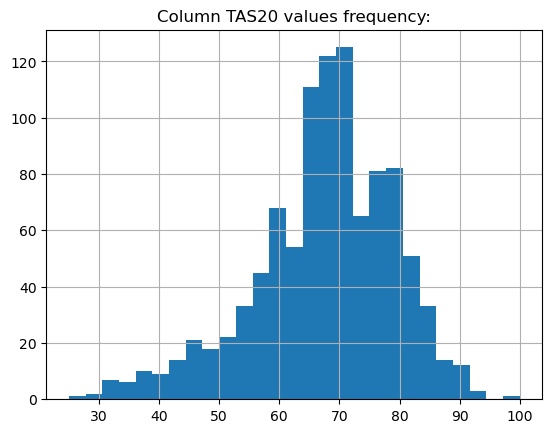

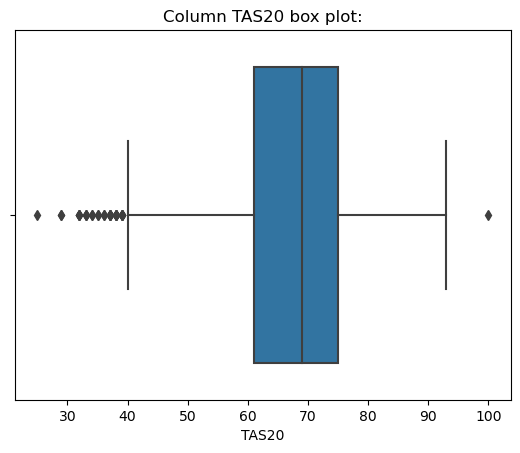

---
Column: F1
Column Type: int64
Sample value: 30
Number of unique values: 29
Percentage of unique values: 2.87%
Number of missing values: 0
Percentage of missing values: 0.00%

     count       mean       std  min   25%   50%   75%   max
F1  1010.0  25.517822  5.550041  7.0  23.0  26.0  29.0  35.0

Sample of outliers: [8, 13, 10, 12, 11, 9, 11, 11, 13, 13]
Sample of outliers over Q3: []
Sample of outliers below Q1: [13, 13, 13, 13, 13, 13, 13, 13, 13, 12]
No inliers detected in column F1
Column F1 values frequency:


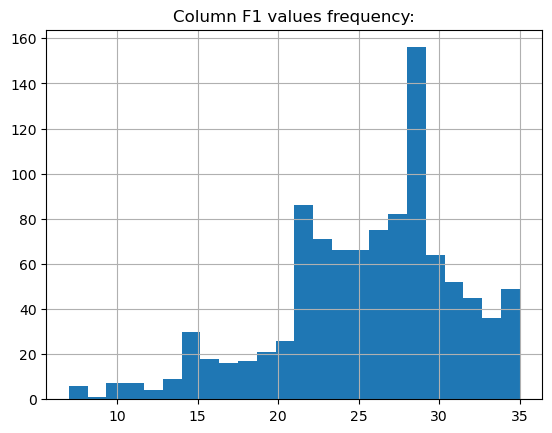

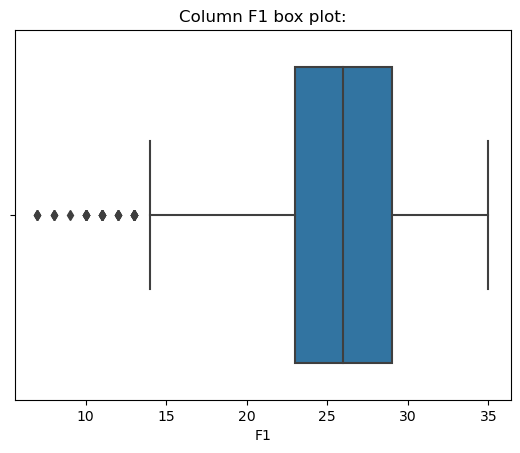

---
Column: F2
Column Type: int64
Sample value: 21
Number of unique values: 21
Percentage of unique values: 2.08%
Number of missing values: 0
Percentage of missing values: 0.00%

     count       mean       std  min   25%   50%   75%   max
F2  1010.0  19.107921  4.170694  5.0  17.0  20.0  22.0  25.0

Sample of outliers: [8, 7, 9, 5, 8, 9, 7, 5, 7, 8]
Sample of outliers over Q3: []
Sample of outliers below Q1: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
No inliers detected in column F2
Column F2 values frequency:


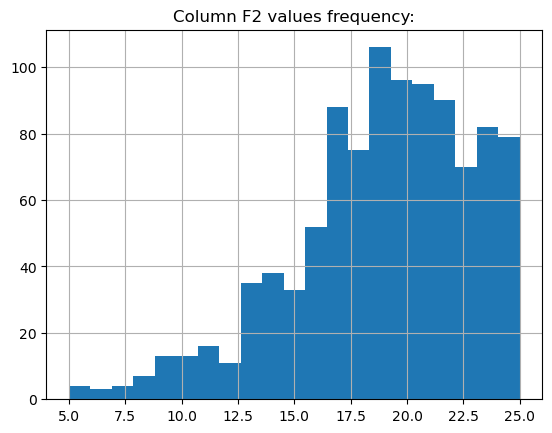

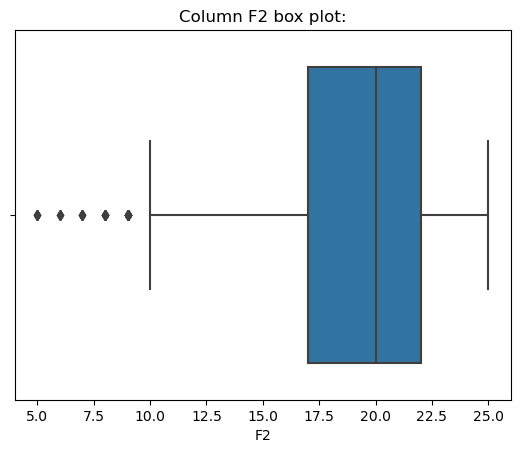

---
Column: F3
Column Type: int64
Sample value: 20
Number of unique values: 31
Percentage of unique values: 3.07%
Number of missing values: 0
Percentage of missing values: 0.00%

     count       mean       std  min   25%   50%    75%   max
F3  1010.0  22.773267  5.364705  8.0  19.0  23.0  26.75  40.0

Sample of outliers: [40, 40, 40]
Sample of outliers over Q3: [40, 40, 40]
Sample of outliers below Q1: []
No inliers detected in column F3
Column F3 values frequency:


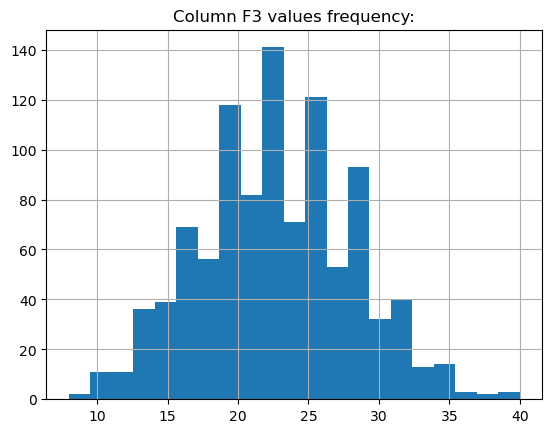

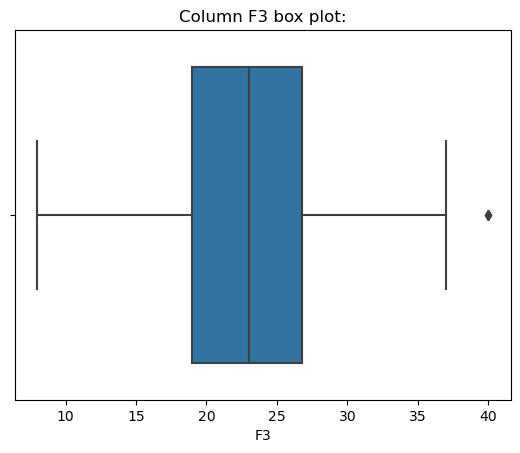

---
Column: Gender
Column Type: int64
Sample value: 2
Number of unique values: 3
Percentage of unique values: 0.30%
Number of missing values: 0
Percentage of missing values: 0.00%

         count      mean       std  min  25%  50%  75%  max
Gender  1010.0  1.880198  0.401316  1.0  2.0  2.0  2.0  3.0

Sample of outliers: [1, 1, 3, 1, 1, 1, 1, 1, 1, 1]
Sample of outliers over Q3: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Sample of outliers below Q1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
No inliers detected in column Gender
Column Gender values frequency:


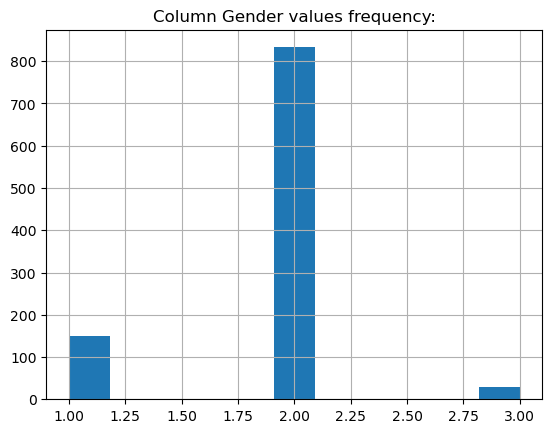

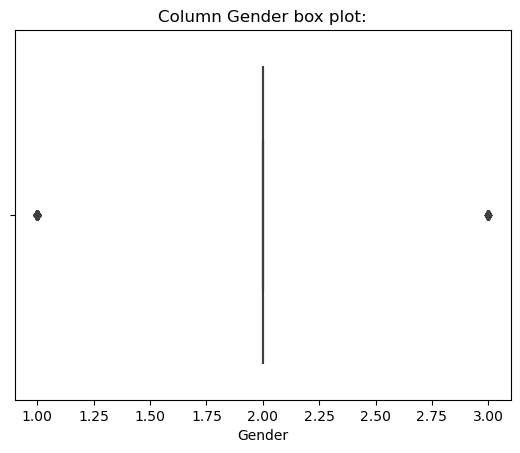

---
Column: Age
Column Type: int64
Sample value: 20
Number of unique values: 45
Percentage of unique values: 4.46%
Number of missing values: 0
Percentage of missing values: 0.00%

      count       mean       std   min   25%   50%   75%   max
Age  1010.0  23.167327  9.057613  18.0  18.0  18.0  24.0  68.0

Sample of outliers: [41, 51, 35, 39, 54, 46, 39, 35, 61, 54]
Sample of outliers over Q3: [34, 34, 35, 35, 35, 35, 35, 35, 35, 35]
Sample of outliers below Q1: []
No inliers detected in column Age
Column Age values frequency:


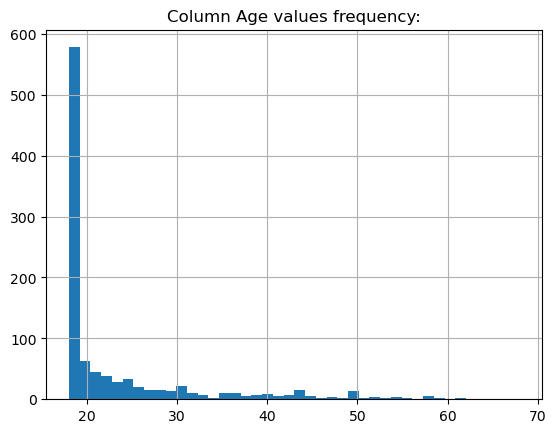

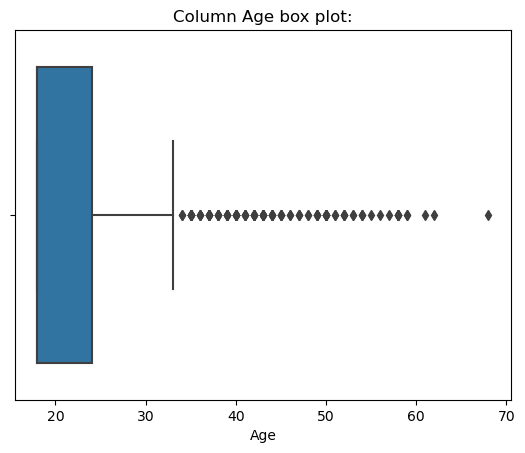

---
Column: Code
Column Type: object
See Converted_Code column below for a detailed analysis.
Sample value: 8b45a0f1b5fad1e453f0ac5ccb905fa7
Number of unique values: 947
Percentage of unique values: 93.76%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: Alexithymia
Column Type: object
See Converted_Alexithymia column below for a detailed analysis.
Sample value: POSITIVE
Number of unique values: 2
Percentage of unique values: 0.20%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: Timestamp (1)
Column Type: object
See Converted_Timestamp (1) column below for a detailed analysis.
Sample value: 2021-03-17T07:39:24.457Z
Number of unique values: 947
Percentage of unique values: 93.76%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: DateDiff_TAS20_NLP
Column Type: int64
Sample value: 0
Number of unique values: 43
Percentage of unique values: 4.26%
Number of missing values: 0
Percentage of missing values: 0.00%


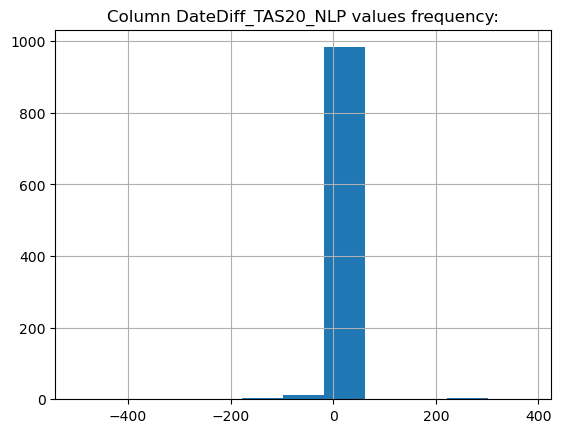

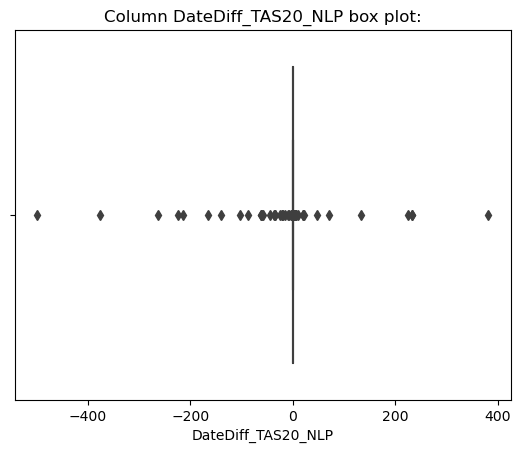

---
Column: Text_Card1
Column Type: object
See Converted_Text_Card1 column below for a detailed analysis.
Sample value:  ... un niño, común, como cualquier otro, salía de casa, iba a la escuela, tenía amigos, su familia lo amaba, no tenía nada que envidiar a nadie, sin embargo, no era feliz, y mucho menos se sentía libre, su sueño se hallaba frente a él, y aunque todo el mundo le decía que podía hacerlo, él no se sentía capaz de hacerlo, por lo cuál, se conformaba con hacer lo que los demás le decían, y aunque por momentos tomara ese violín y se sentía en el paraíso, no lograba permanecer ahí mucho tiempo, pues la realidad siempre lo alcanzaba y lo hacía regresar a esa vida, a la que todo el mundo le decía que estaba destinado.

Number of unique values: 945
Percentage of unique values: 93.56%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: Text_Card9VH
Column Type: object
See Converted_Text_Card9VH column below for a detailed analysis.
Sample value:  ... un 

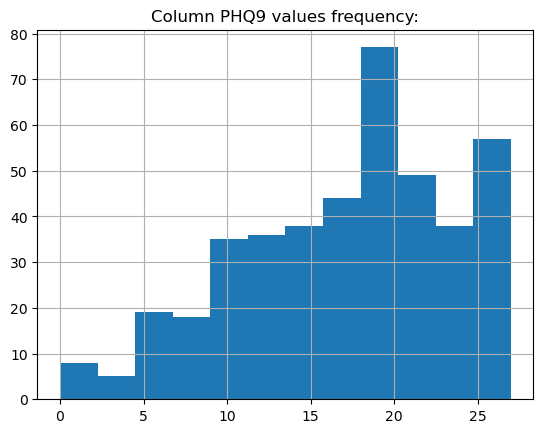

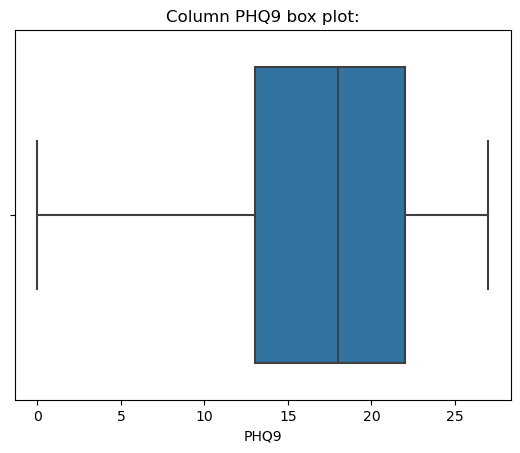

---
Column: I1
Column Type: float64
Sample value: 3.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min  25%  50%  75%  max
I1  424.0  2.068396  0.963907  0.0  1.0  2.0  3.0  3.0

There are no outliers in column I1
No inliers detected in column I1
Column I1 values frequency:


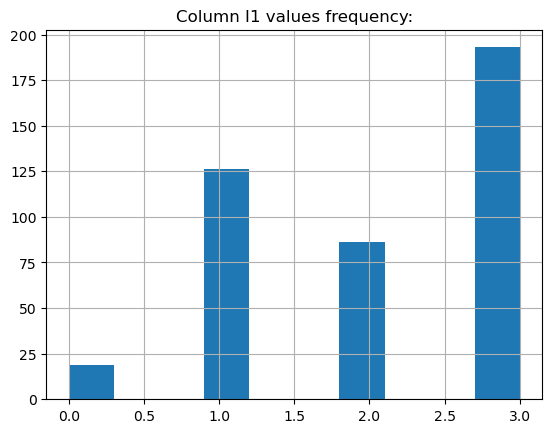

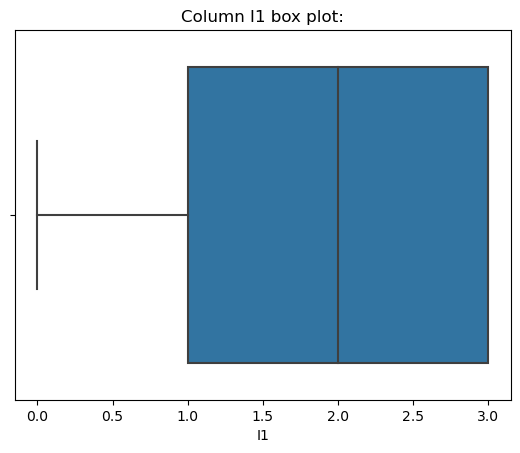

---
Column: I2
Column Type: float64
Sample value: 2.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min  25%  50%  75%  max
I2  424.0  1.976415  0.979415  0.0  1.0  2.0  3.0  3.0

There are no outliers in column I2
No inliers detected in column I2
Column I2 values frequency:


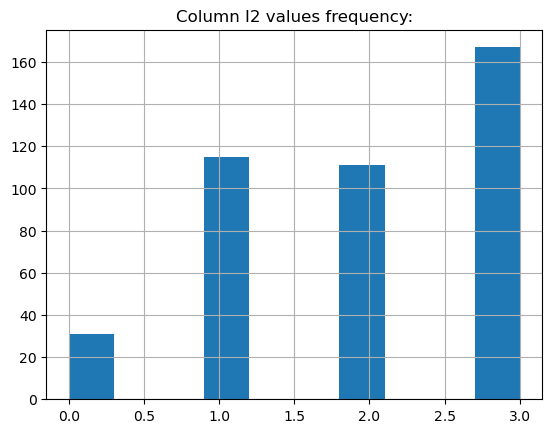

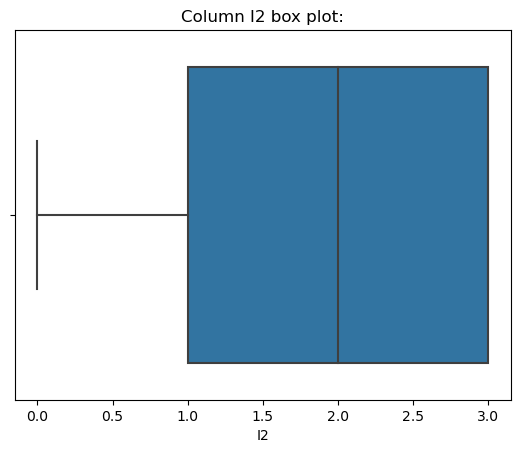

---
Column: I3
Column Type: float64
Sample value: 2.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min   25%  50%  75%  max
I3  424.0  2.238208  0.973576  0.0  1.75  3.0  3.0  3.0

There are no outliers in column I3
No inliers detected in column I3
Column I3 values frequency:


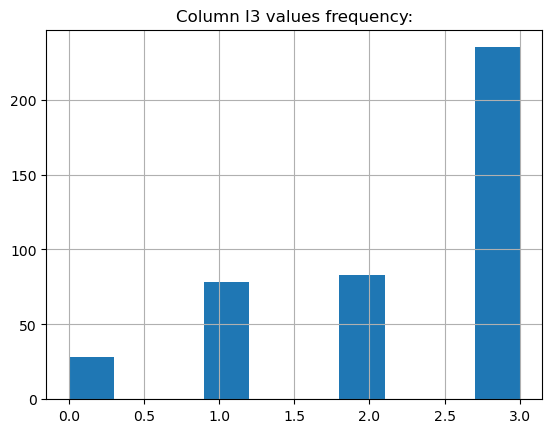

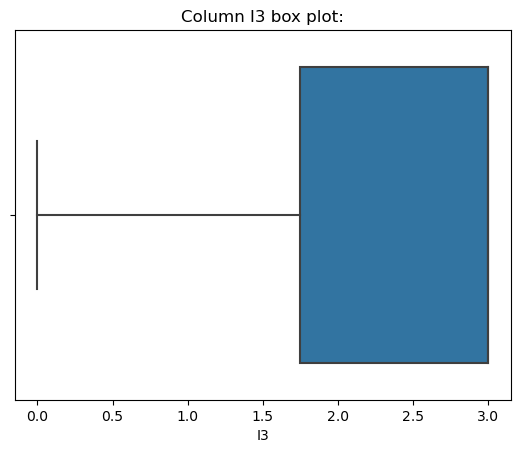

---
Column: I4
Column Type: float64
Sample value: 3.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min  25%  50%  75%  max
I4  424.0  2.207547  0.929851  0.0  1.0  3.0  3.0  3.0

There are no outliers in column I4
No inliers detected in column I4
Column I4 values frequency:


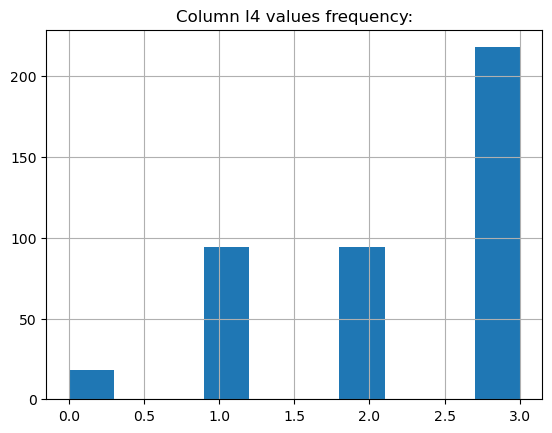

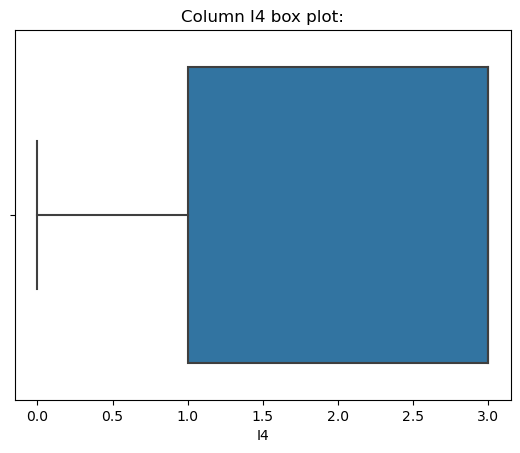

---
Column: I5
Column Type: float64
Sample value: 2.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min  25%  50%  75%  max
I5  424.0  2.028302  1.046959  0.0  1.0  2.0  3.0  3.0

There are no outliers in column I5
No inliers detected in column I5
Column I5 values frequency:


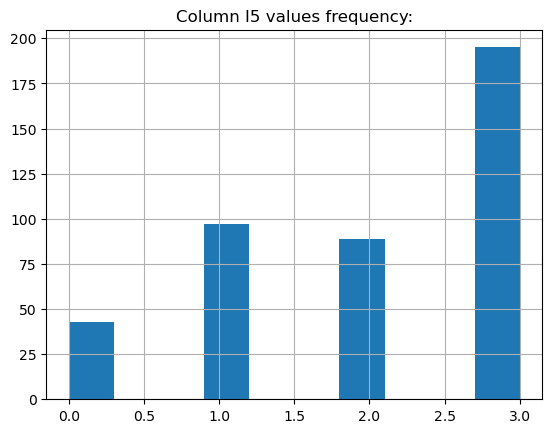

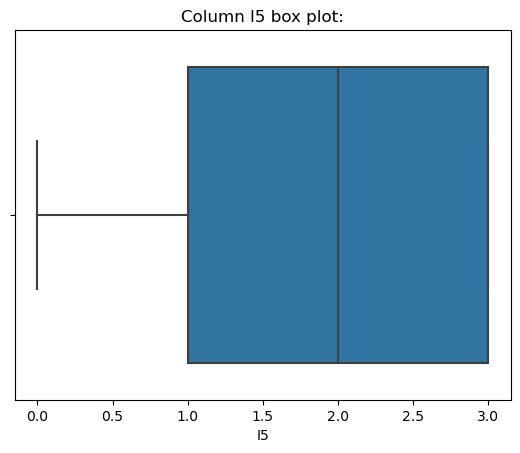

---
Column: I6
Column Type: float64
Sample value: 3.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min  25%  50%  75%  max
I6  424.0  2.148585  1.031008  0.0  1.0  3.0  3.0  3.0

There are no outliers in column I6
No inliers detected in column I6
Column I6 values frequency:


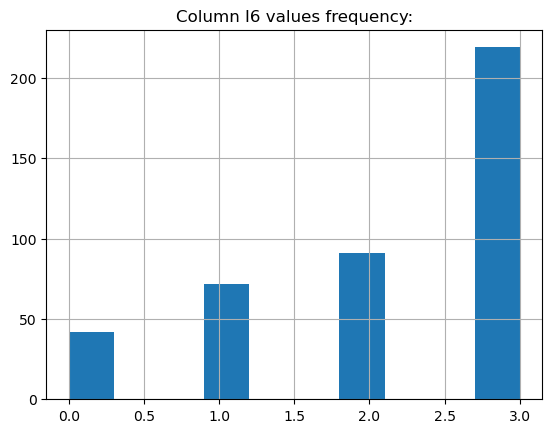

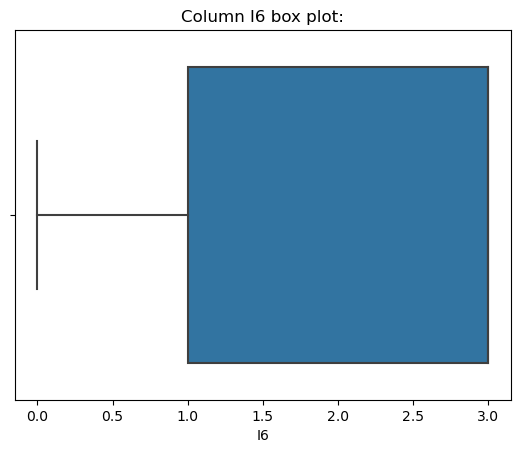

---
Column: I7
Column Type: float64
Sample value: 3.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count     mean       std  min  25%  50%  75%  max
I7  424.0  1.71934  1.104045  0.0  1.0  2.0  3.0  3.0

There are no outliers in column I7
No inliers detected in column I7
Column I7 values frequency:


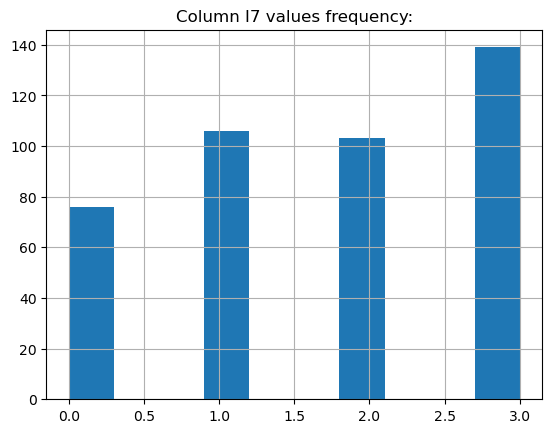

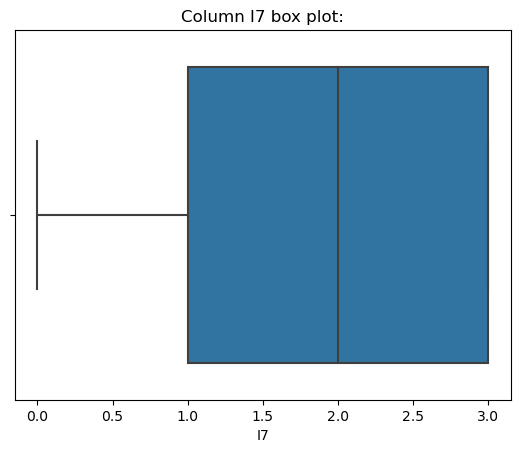

---
Column: I8
Column Type: float64
Sample value: 1.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min  25%  50%  75%  max
I8  424.0  1.254717  1.109267  0.0  0.0  1.0  2.0  3.0

There are no outliers in column I8
No inliers detected in column I8
Column I8 values frequency:


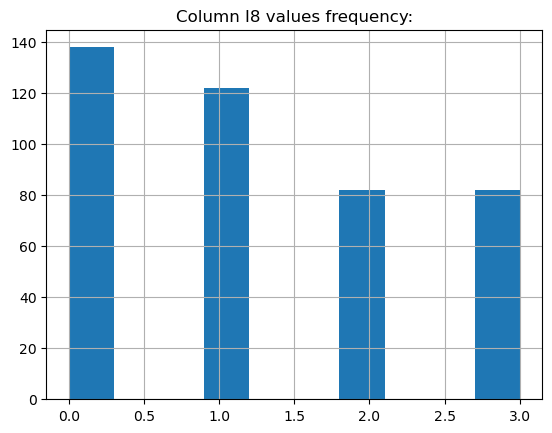

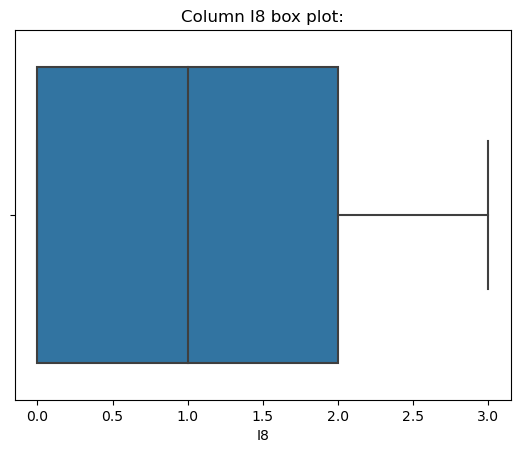

---
Column: I9
Column Type: float64
Sample value: 0.0
Number of unique values: 5
Percentage of unique values: 0.50%
Number of missing values: 586
Percentage of missing values: 58.02%

    count      mean       std  min  25%  50%  75%  max
I9  424.0  1.448113  1.213457  0.0  0.0  1.0  3.0  3.0

There are no outliers in column I9
No inliers detected in column I9
Column I9 values frequency:


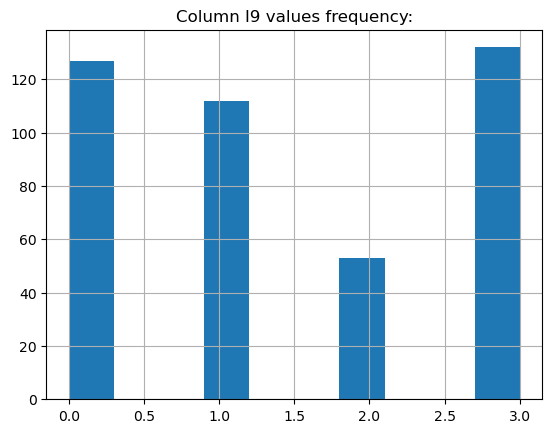

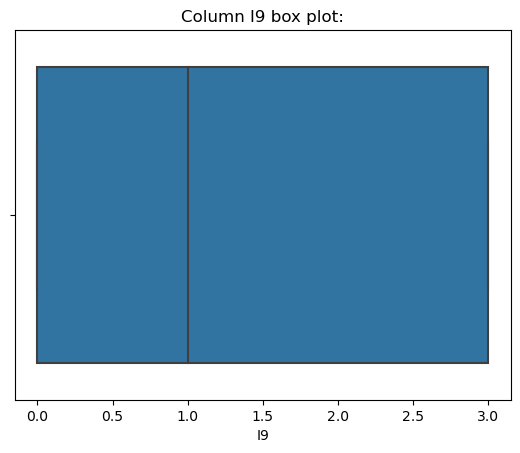

---
Column: Depression
Column Type: object
See Converted_Depression column below for a detailed analysis.
Sample value: POSITIVE
Number of unique values: 3
Percentage of unique values: 0.30%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: BAI
Column Type: float64
Sample value: 19.0
Number of unique values: 61
Percentage of unique values: 6.04%
Number of missing values: 576
Percentage of missing values: 57.03%

     count       mean        std  min   25%   50%   75%   max
BAI  434.0  29.864055  13.417869  1.0  20.0  29.0  39.0  72.0

Sample of outliers: [69.0, 72.0, 72.0, 72.0]
Sample of outliers over Q3: [69.0, 72.0, 72.0, 72.0]
Sample of outliers below Q1: []
No inliers detected in column BAI
Column BAI values frequency:


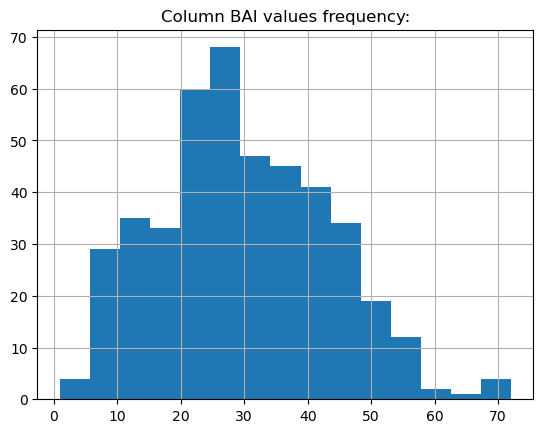

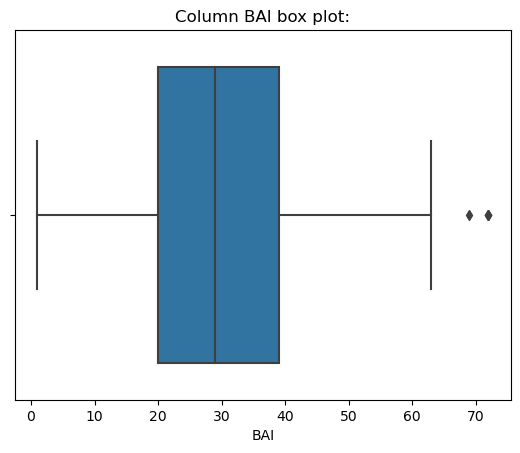

---
Column: Anxiety
Column Type: object
See Converted_Anxiety column below for a detailed analysis.
Sample value: POSITIVE
Number of unique values: 3
Percentage of unique values: 0.30%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: PSS
Column Type: float64
Sample value: 41.0
Number of unique values: 44
Percentage of unique values: 4.36%
Number of missing values: 665
Percentage of missing values: 65.84%

     count       mean       std   min   25%   50%   75%   max
PSS  345.0  37.614493  8.297122  12.0  33.0  38.0  43.0  69.0

Sample of outliers: [13.0, 69.0, 12.0, 13.0, 60.0, 13.0, 12.0, 16.0, 62.0, 13.0]
Sample of outliers over Q3: [60.0, 60.0, 62.0, 69.0]
Sample of outliers below Q1: [16.0, 13.0, 13.0, 13.0, 13.0, 12.0, 12.0]
No inliers detected in column PSS
Column PSS values frequency:


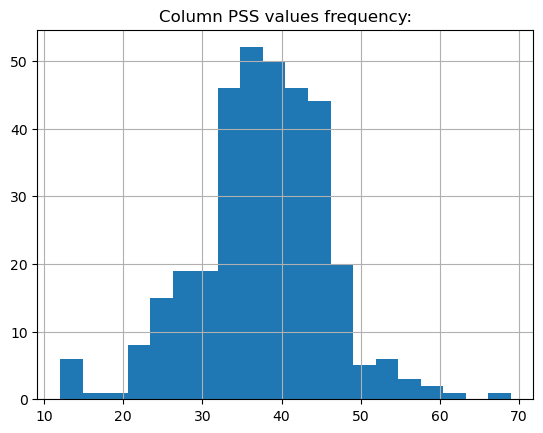

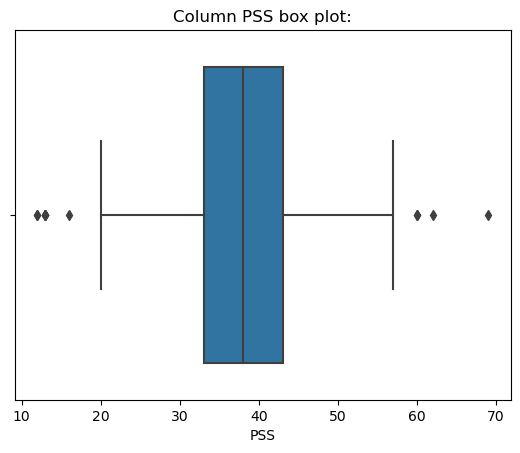

---
Column: AN
Column Type: float64
Sample value: 37.0
Number of unique values: 42
Percentage of unique values: 4.16%
Number of missing values: 570
Percentage of missing values: 56.44%

    count       mean       std   min   25%   50%   75%   max
AN  440.0  30.220455  9.225055  10.0  24.0  29.0  37.0  50.0

There are no outliers in column AN
No inliers detected in column AN
Column AN values frequency:


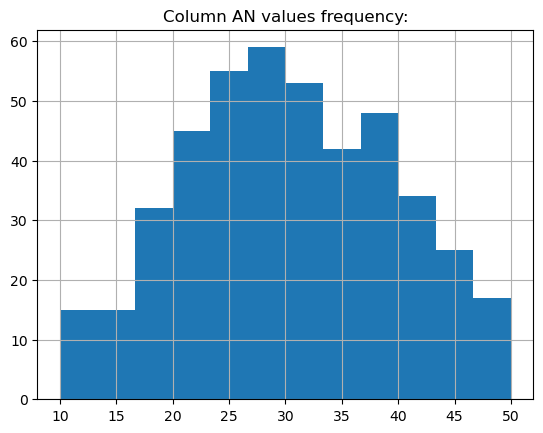

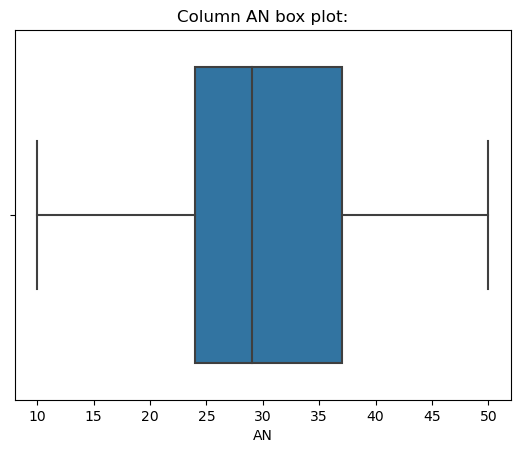

---
Column: AP
Column Type: float64
Sample value: 14.0
Number of unique values: 35
Percentage of unique values: 3.47%
Number of missing values: 570
Percentage of missing values: 56.44%

    count    mean       std   min   25%   50%   75%   max
AP  440.0  23.075  7.113868  10.0  17.0  23.0  28.0  47.0

Sample of outliers: [47.0, 46.0]
Sample of outliers over Q3: [46.0, 47.0]
Sample of outliers below Q1: []
No inliers detected in column AP
Column AP values frequency:


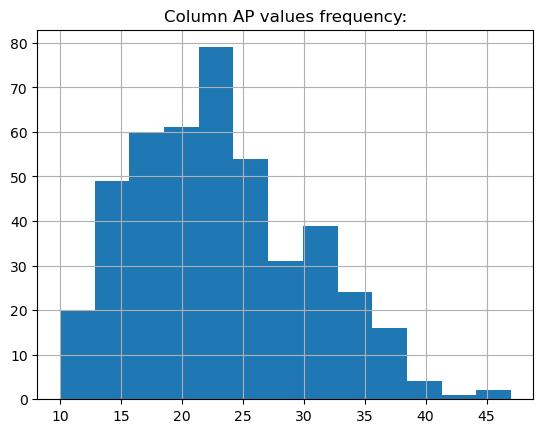

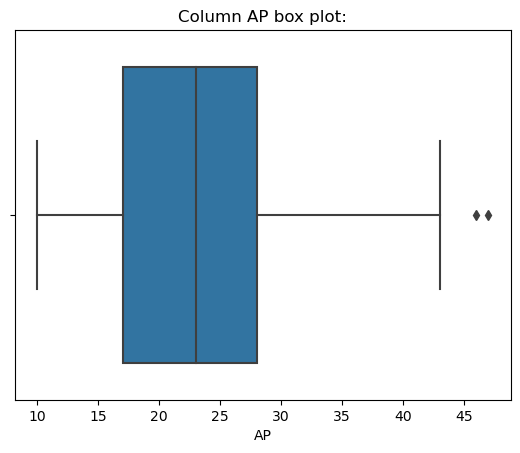

---
Column: Text_Card1_en
Column Type: object
See Converted_Text_Card1_en column below for a detailed analysis.
Sample value: ... a common child, like any other, left home, went to school, had friends, his family loved him, he had nothing to envy anyone, however, he was not happy, let alone felt free , his dream was in front of him, and although everyone told him that he could do it, he did not feel capable of doing it, for which, he was content to do what others told him, and although at times he took that violin and he felt in paradise, he could not stay there for long, because reality always caught up with him and made him return to that life, to which everyone told him he was destined.
Number of unique values: 943
Percentage of unique values: 93.37%
Number of missing values: 0
Percentage of missing values: 0.00%
---
Column: Text_Card9VH_en
Column Type: object
See Converted_Text_Card9VH_en column below for a detailed analysis.
Sample value: ... a man who was drunk with his friends
N

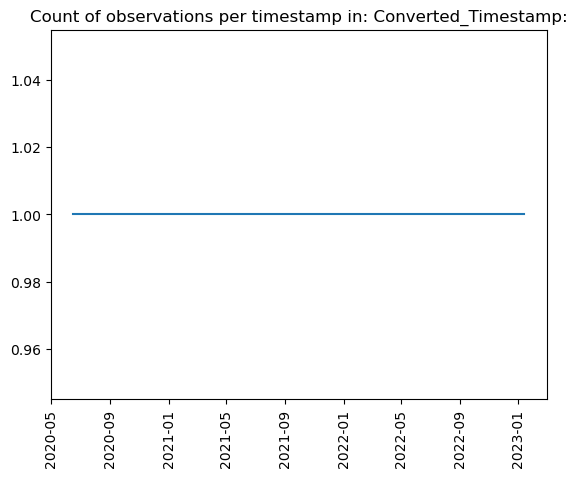

Count of observations per date (day) in: Converted_Timestamp:


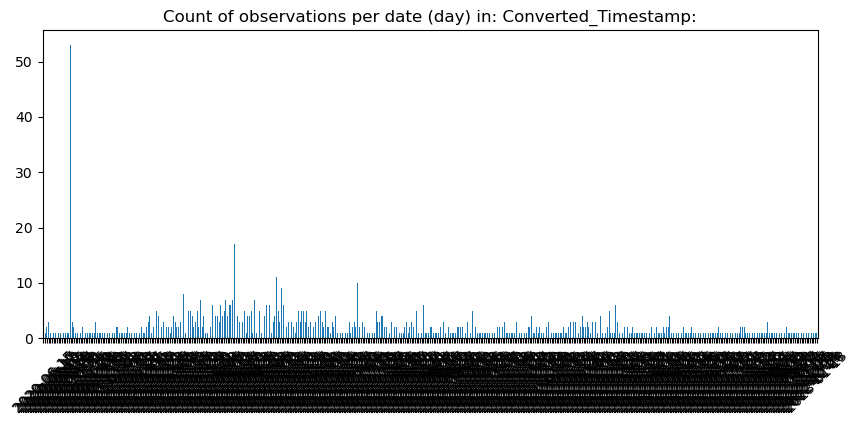

Observations per month of the year in Converted_Timestamp


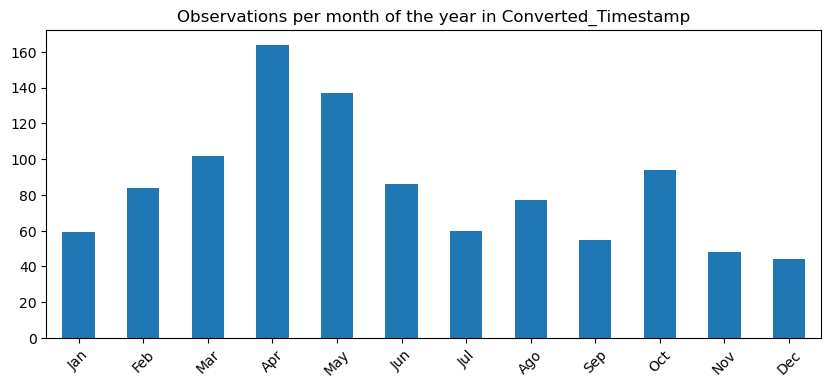

Observations per day of the month in Converted_Timestamp


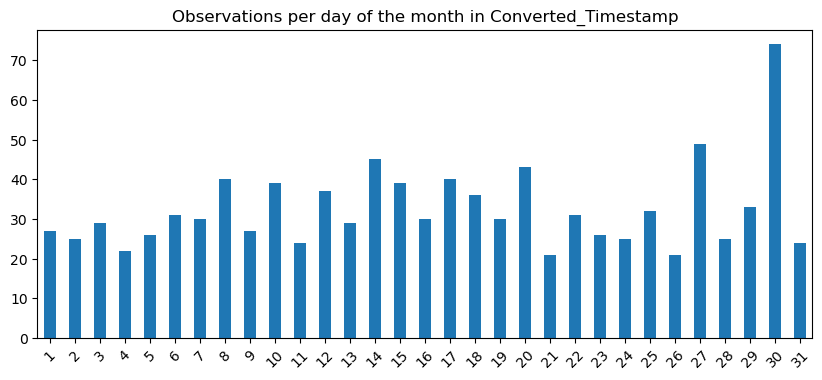

Observations per hour of the day in Converted_Timestamp


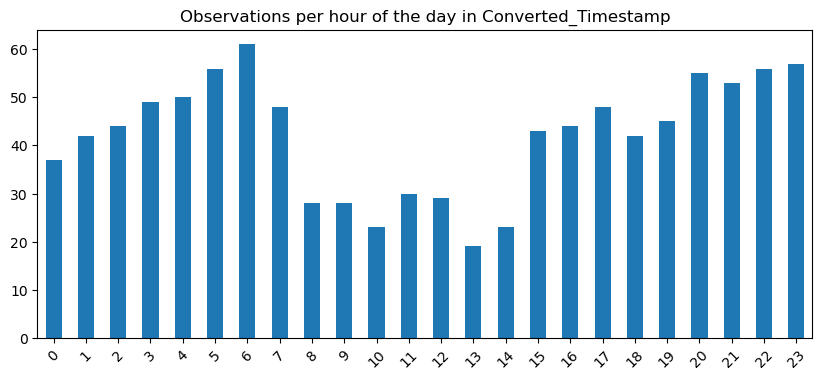

Observations per day of the week in Converted_Timestamp


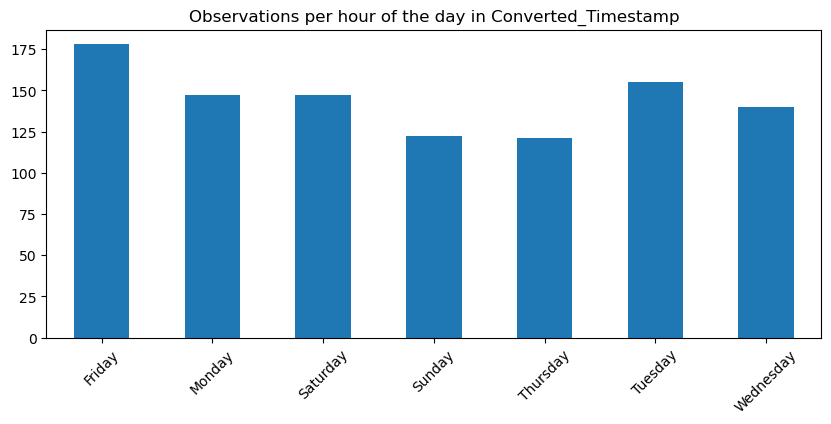

---
Column: Converted_Timestamp (1)
Column Type: datetime64[ns, UTC]
Sample value: 2021-03-17 07:39:24.457000+00:00
Number of unique values: 947
Percentage of unique values: 93.76%
Number of missing values: 0
Percentage of missing values: 0.00%
Global Series Start Datetime: 2020-06-15 14:28:25.641000+00:00
Global Series End Datetime: 2023-01-13 04:51:51.436000+00:00
Global Series Period: 941 days 14:23:25.795000
Count of observations per timestamp in: Converted_Timestamp (1):


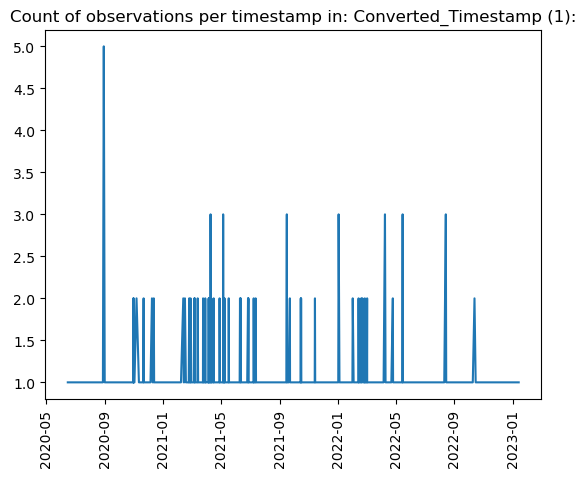

Count of observations per date (day) in: Converted_Timestamp (1):


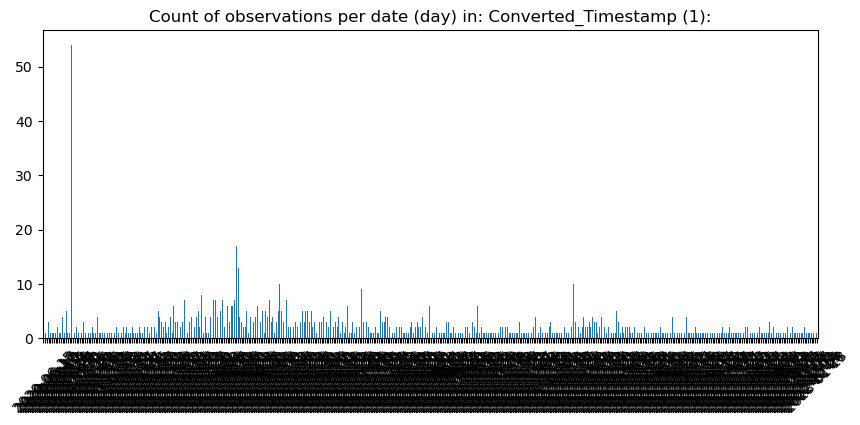

Observations per month of the year in Converted_Timestamp (1)


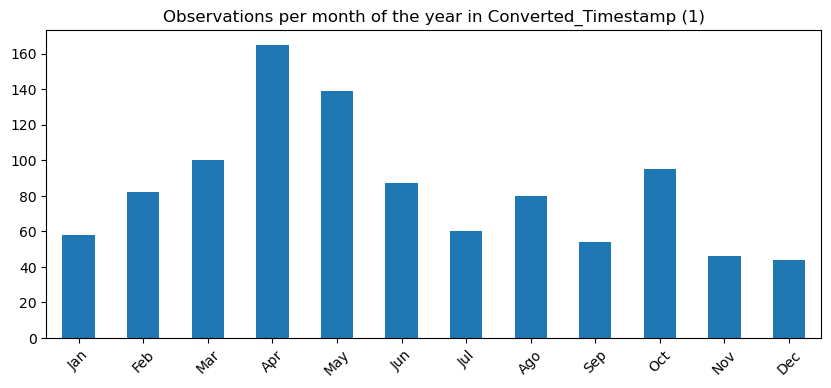

Observations per day of the month in Converted_Timestamp (1)


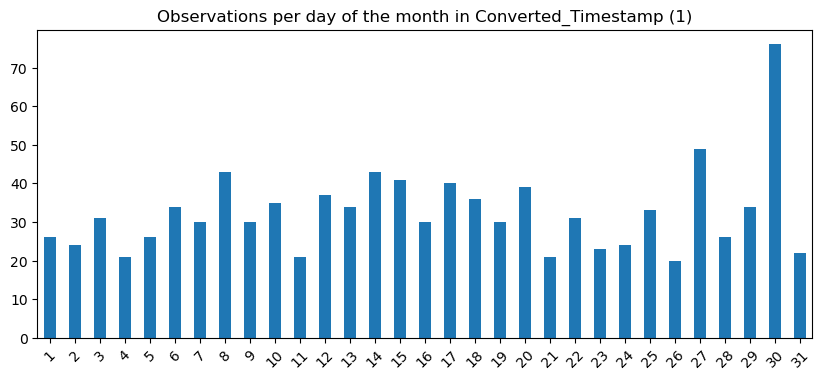

Observations per hour of the day in Converted_Timestamp (1)


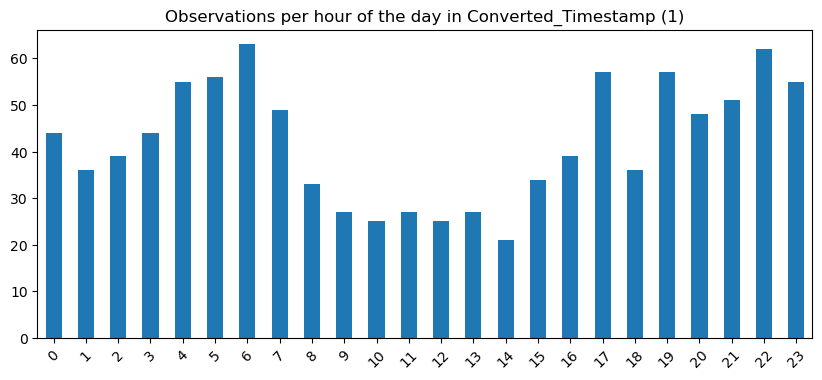

Observations per day of the week in Converted_Timestamp (1)


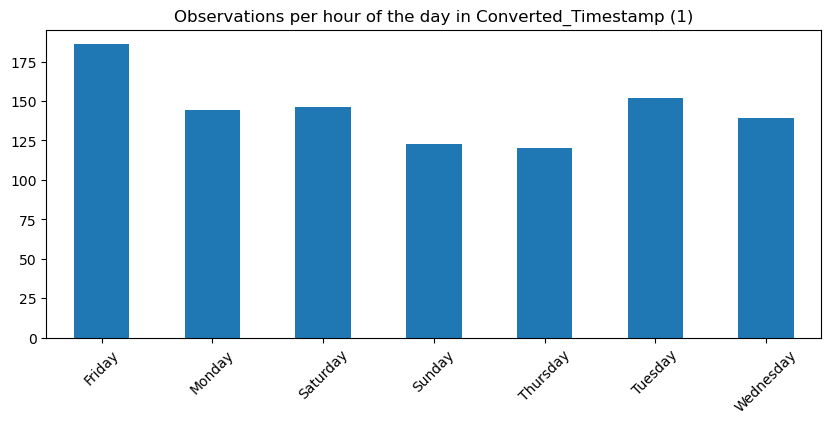

---


<Figure size 640x480 with 0 Axes>

In [19]:
blank_line(pdf)
duoprint("Columns Univariate Analysis", pdf, box=True)

for c in df.columns: 
    blank_line(pdf)
    
    # COLUMN NAME
    col_name = "Column: " + c
    duoprint(col_name, pdf, marker=True)
    
    # COLUMN TYPE
    type_info = "Column Type: " + str(df[c].dtype)
    duoprint(type_info, pdf)
    
    # OBJECT COLUMNS ARE ANALYZED USING THEIR "Converted_" versions
    if df[c].dtype == 'object':
        duoprint("See Converted_" + c + " column below for a detailed analysis.", pdf, warning=True)
        
    # SAMPLE VALUE
    sample_info = "Sample value: " + str(df[c].sample(n=1, ignore_index=True, random_state=r_seed).iloc[-1])
    duoprint(sample_info, pdf)
    
    # NUMBER OF UNIQUE VALUES
    num_unique = len(df[c].unique())
    num_unique_info = "Number of unique values: " + str(num_unique)
    duoprint(num_unique_info, pdf)
    
    # PERCENTAGE OF UNIQUE VALUES
    pct_unique = (num_unique/n_rows)*100
    pct_unique_info = f'Percentage of unique values: {pct_unique:.2f}%'
    duoprint(pct_unique_info, pdf)
    
    # NUMBER OF MISSING VALUES
    num_missing = df[c].isna().sum()
    num_missing_info = "Number of missing values: " + str(num_missing)
    duoprint(num_missing_info, pdf)
    
    # PERCENTAGE OF MISSING VALUES
    pct_missing = (num_missing/n_rows)*100
    pct_unique_info = f'Percentage of missing values: {pct_missing:.2f}%'
    duoprint(pct_unique_info, pdf)
    if (pct_missing > PCT_MISSING_THRESHOLD):
        duoprint("Warning: too missing values in column " + c, pdf, warning=True)
    
    # For time series features
    if is_datetime(df[c]):
        start_date = df[c].min()
        duoprint(f'Global Series Start Datetime: {start_date}',pdf)
        end_date = df[c].max()
        duoprint(f'Global Series End Datetime: {end_date}',pdf)
        period_length = end_date - start_date
        duoprint(f'Global Series Period: {period_length}',pdf)
        
        # A df with observation counts per timestamp
        ts_df = pd.DataFrame(df[c].value_counts().reset_index())
        ts_df.columns = ['datetime', 'count']
        
        # Order timestamps
        ts_df['datetime'] = pd.to_datetime(ts_df['datetime'])
        ts_df = ts_df.sort_values('datetime', ascending=True)
        
        # Plot observations count per timestamp
        ts_count_info = "Count of observations per timestamp in: " + c + ":"
        ts_count_img = './imgs/ts_count_'+c+'.png'
        duoprint(ts_count_info, pdf)
        
        plt.plot(ts_df['datetime'], ts_df['count'])
        plt.xticks(rotation='vertical')
        plt.title(ts_count_info)
        plt.savefig(ts_count_img, transparent=False, facecolor='white', bbox_inches="tight")        
        plt.show()
        plt.clf()
        pdf.image(ts_count_img, x=10, y=None, w=140, h=0, type='PNG')
        
        # Plot observations count per date (day)
        ts_date_info = "Count of observations per date (day) in: " + c + ":"
        ts_date_img = './imgs/ts_count_date_'+c+'.png'
        duoprint(ts_date_info, pdf)
        
        date_ts = ts_df.groupby(ts_df.datetime.dt.date)['count'].sum()
        date_ts.plot(x='datetime', y='count', kind='bar', rot=45, legend=None, 
                        title=ts_date_info, xlabel='', fontsize=10, figsize=(10,4));
        plt.savefig(ts_date_img, transparent=False, facecolor='white', bbox_inches="tight")  
        plt.show()
        plt.clf()
        pdf.image(ts_date_img, x=10, y=None, w=140, h=0, type='PNG')

        
        # Plot observations count per month of the year
        ts_monthly_info = 'Observations per month of the year in ' + c
        ts_monthly_img = './imgs/ts_count_monthly_'+c+'.png'
        duoprint(ts_monthly_info, pdf)
        
        monthly_ts = ts_df.groupby(ts_df.datetime.dt.month)['count'].sum()
        monthly_ts.index = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dec']
        monthly_ts.plot(x='datetime', y='count', kind='bar', rot=45, legend=None, 
                        title=ts_monthly_info, xlabel='', fontsize=10, figsize=(10,4));
        plt.savefig(ts_monthly_img, transparent=False, facecolor='white', bbox_inches="tight")  
        plt.show()
        plt.clf()
        pdf.image(ts_monthly_img, x=10, y=None, w=140, h=0, type='PNG')
        
        # Plot observations count per day of the month
        ts_daily_info = 'Observations per day of the month in ' + c
        ts_daily_img = './imgs/ts_count_daily_'+c+'.png'
        duoprint(ts_daily_info, pdf)
        
        daily_ts = ts_df.groupby(ts_df.datetime.dt.day)['count'].sum()
        daily_ts.plot(x='datetime', y='count', kind='bar', rot=45, legend=None, 
                      title=ts_daily_info, xlabel='', fontsize=10, figsize=(10,4));
        plt.savefig(ts_daily_img, transparent=False, facecolor='white', bbox_inches="tight")  
        plt.show()
        plt.clf()
        pdf.image(ts_daily_img, x=10, y=None, w=140, h=0, type='PNG')
        
        # Plot observations count per hour of the day
        ts_hourly_info = 'Observations per hour of the day in ' + c
        ts_hourly_img = './imgs/ts_count_hourly_'+c+'.png'
        duoprint(ts_hourly_info, pdf)
        
        hourly_ts = ts_df.groupby(ts_df['datetime'].dt.hour)['count'].sum()
        hourly_ts.plot(x='datetime', y='count', kind='bar', rot=45, legend=None, 
                       title=ts_hourly_info, xlabel='', fontsize=10, figsize=(10,4))
        plt.savefig(ts_hourly_img, transparent=False, facecolor='white', bbox_inches="tight")  
        plt.show()
        plt.clf()
        pdf.image(ts_hourly_img, x=10, y=None, w=140, h=0, type='PNG')    
        
        # Plot observations count per day of the week
        ts_dayweek_info = 'Observations per day of the week in ' + c
        ts_dayweek_img = './imgs/ts_count_dayweek_'+c+'.png'
        duoprint(ts_dayweek_info, pdf)
        
        dayweek_ts = ts_df.groupby(ts_df['datetime'].dt.day_name())['count'].sum()
        dayweek_ts.plot(x='datetime', y='count', kind='bar', rot=45, legend=None, 
                       title=ts_hourly_info, xlabel='', fontsize=10, figsize=(10,4))
        plt.savefig(ts_dayweek_img, transparent=False, facecolor='white', bbox_inches="tight")  
        plt.show()
        plt.clf()
        pdf.image(ts_dayweek_img, x=10, y=None, w=140, h=0, type='PNG')           
    
    # For numeric features
    if (df[c].dtype.kind in 'iufc'): 
        
        # Transposed stats description
        df_desc_t = pd.DataFrame(np.array(df[c].describe().tolist()), columns=[c]).T
        df_desc_t.columns = df[c].describe().index.tolist()
        
        # stats desc df
        df_desc = pd.DataFrame({'Stats':df[c].describe().index.tolist(),
                                 c:df[c].describe().tolist()})    
        
        print_table(df_desc, "Column Statistics", pdf)
        blank_line(pdf)
        print()
        print(df_desc_t)       
        print()
        
        # Outliers 
        outs_df = get_IQR_outliers(df[c], mode='all')
        outs_df_top = get_IQR_outliers(df[c], mode='largest')
        outs_df_down = get_IQR_outliers(df[c], mode='smallest')
        
        if (len(outs_df) < 1):
            duoprint("There are no outliers in column " + c, pdf)
        else:
            duoprint("Warning: There are outliers in column " + c, pdf, warning=True)
            
            n_outs = min(DISPLAY_NUM_SAMPLE_SIZE,len(outs_df))
            n_outs_top = min(DISPLAY_NUM_SAMPLE_SIZE,len(outs_df_top))
            n_outs_down = min(DISPLAY_NUM_SAMPLE_SIZE,len(outs_df_down))
            
            duoprint("Sample of outliers: " + str(outs_df.sample(n_outs).tolist()), pdf)
            duoprint("Sample of outliers over Q3: " + str(outs_df_top.sort_values(ascending=True).head(n_outs_top).tolist()), pdf)
            duoprint("Sample of outliers below Q1: " + str(outs_df_down.sort_values(ascending=False).head(n_outs_down).tolist()), pdf)
        
        # Inliers
        inliers_df = get_possible_inliers(df[c])
        
        if (len(inliers_df) < 1):
            duoprint("No inliers detected in column " + c, pdf)
        else:
            n_ins = min(DISPLAY_NUM_SAMPLE_SIZE,len(inliers_df))
            duoprint("Warning: possible inliers in column " + c, pdf, warning=True)
            duoprint("Sample of inliers: " + str(inliers_df.sample(n_ins).tolist()), pdf)
            
    
    # For numeric and boolean features
    # biufc: b bool, i int (signed), u unsigned int, f float, c complex
    if (df[c].dtype.kind in 'biufc'): 
        
        # print("Generating histogram...")
        hist_info = "Column " + c + " values frequency:"
        hist = df[c].hist(bins='auto')
        hist_img = './imgs/hist_'+c+'.png'
        duoprint(hist_info, pdf)
        plt.title(hist_info)
        plt.savefig(hist_img, transparent=False, facecolor='white', bbox_inches="tight")        
        plt.show()
        plt.clf()
        pdf.image(hist_img, x = 10, y = None, w = 100, h = 0, type = 'PNG')
    
        # print("Generating boxplot...")
        boxplot_info = "Column " + c + " box plot:"
        boxplot_img = './imgs/bp_'+c+'.png'
        sns.boxplot(x=df[c])
        plt.title(boxplot_info)
        plt.savefig(boxplot_img, transparent=False, facecolor='white', bbox_inches="tight") 
        plt.show()
        plt.clf()
        pdf.image(boxplot_img, x = 10, y = None, w = 100, h = 0, type = 'PNG')

    print("---")
    # input("Press any key")

In [20]:
pdf.output(f'./EDA_report.pdf', 'F')

''

### Data Quality check

#### Label quality check (for supervised learning)

### Correlational Analysis